# 4.a Model Development (Method 1)

### Import Necessary Packages

In [15]:
# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Libraries to split data, impute missing values
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
# Libraries to import decision tree classifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Libtune to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance
import io  
import joblib
import tarfile
from sagemaker.sklearn.model import SKLearnModel

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


## Load data from S3

In [38]:
role

'arn:aws:iam::190183093544:role/service-role/AmazonSageMaker-ExecutionRole-20220602T141236'

In [18]:
session = boto3.Session()

In [19]:
bucket='data-aman-use-case'  
file_key = 'X.csv' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
X = pd.read_csv(io.BytesIO(obj['Body'].read()))  

In [20]:
bucket='data-aman-use-case'  
file_key = 'y.csv' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
y = pd.read_csv(io.BytesIO(obj['Body'].read()))  

### Load Data

In [21]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

### Split the Train and Test Data 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1
)

In [23]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (194357, 143)
Shape of test set :  (83297, 143)
Percentage of classes in training set:
Data_prediction
0                  0.500116
1                  0.499884
dtype: float64
Percentage of classes in test set:
Data_prediction
1                  0.50027
0                  0.49973
dtype: float64


Earlier we coverted 0 to being smooth and 1 being congested <br> Above we see that 70% of the data is in the Training set and 30% of the data is in the test set

### Convert and upload data to S3

In [30]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [31]:
s3 = session.resource('s3') 
local_path = 'X_train.csv' 
s3_filename =  'X_train.csv' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [32]:
s3 = session.resource('s3') 
local_path = 'y_train.csv' 
s3_filename =  'y_train.csv' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [33]:
s3 = session.resource('s3') 
local_path = 'X_test.csv' 
s3_filename =  'X_test.csv' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [34]:
s3 = session.resource('s3') 
local_path = 'y_test.csv' 
s3_filename =  'y_test.csv' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


### Defining functions to get the model performance metrics and build the confusion matrix 

In [35]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [36]:
#defining function to build the confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Build Decision Tree Model 

Training performance:
    Accuracy    Recall  Precision        F1
0  0.994731  0.994329   0.995128  0.994728
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.994225  0.994145   0.994312  0.994228


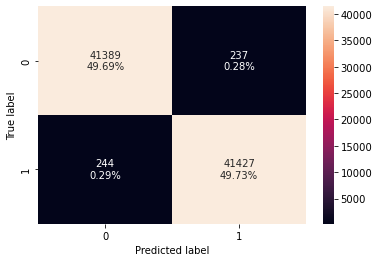

In [26]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree, X_train,y_train)
print("Training performance:\n", d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree, X_test,y_test)
print("Testing performance:\n", d_tree_model_test_perf)
#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)


We get good results with around 99.5% accuracy on the training set and a similar 99.4% accuray on the testing set. <br> We also notice that all the metrics have more than 99% perfromance on both the training and the testing set. <br> To further check what features are most important we will check two more models using random forest classifier and XG Boost and we expect to obtain simmilar results in terms of performance.

### Save model

In [27]:
path = os.path.join("model.joblib")
joblib.dump(d_tree, path)

['model.joblib']

### SageMaker deployment

In [28]:
with tarfile.open('model.tar.gz', "w:gz") as tar:
    tar.add('model.joblib')

In [29]:
session = boto3.Session()
s3 = session.resource('s3')

local_path = 'model.tar.gz' 
s3_filename =  'model.tar.gz' 
result = s3.Bucket(bucket).upload_file(local_path, s3_filename)  
print(result)

None


In [39]:
sm_model = SKLearnModel(
    model_data='s3://' + bucket + '/model.tar.gz',
    role=get_execution_role(),
    entry_point='script.py',
    framework_version='0.23-1')

In [41]:
predictor = sm_model.deploy(
    instance_type='ml.c5.large',
    initial_instance_count=1)

-----!

In [ ]:
pred_test = predictor.predict(X_test)

In [ ]:
pred_test[0:10]

### Clean up

In [ ]:
predictor.delete_endpoint() 

In [ ]:
predictor.delete_model()

### Bussiness Insights  

The Five most important features to build the model to predict the traffic status are as follows: <br> 1. Fastest Route Time <br> 2. Fastest Route Distance <br> 3. Destination Location <br> 4. Starting Location <br> 5. Day of the Week <br> With these features being given, current traffic situation can be predicted accurately.